# Create a custom workflow on distributed processes {#ref_distributed_workflows_on_remote}

This example shows how to read and postprocess distributed files on
distributed processes. After remote postprocessing, results are merged
on the local process. This example creates different operator sequences
directly on different servers. These operators are then connected
together so that you don\'t have to care that they are on remote
processes.

::: graphviz

digraph foo {

:   graph \[pad=\"0\", nodesep=\"0.3\", ranksep=\"0.3\"\] node
    \[shape=box, style=filled, fillcolor=\"#ffcc00\", margin=\"0\"\];
    rankdir=LR; splines=line;

    subgraph cluster_1 {

    :   ds01 \[label=\"data_src\", shape=box, style=filled,
        fillcolor=cadetblue2\];

        ds01 -\> stress1 \[style=dashed\];

        label=\"Server 1\"; style=filled; fillcolor=lightgrey;

    }

    subgraph cluster_2 {

    :   ds02 \[label=\"data_src\", shape=box, style=filled,
        fillcolor=cadetblue2\];

        ds02 -\> stress2 \[style=dashed\]; stress2 -\> mul;

        label=\"Server 2\"; style=filled; fillcolor=lightgrey;

    }

    stress1 -\> \"merge\"; mul -\> \"merge\";

}
:::


Import the `dpf-core` module and its examples files.


In [1]:
import os
from ansys.dpf import core as dpf
from ansys.dpf.core import examples
from ansys.dpf.core import operators as ops

Configure the servers. To make it easier, this example starts local
servers. However, you can connect to any existing servers on your
network.


In [2]:
config = dpf.AvailableServerConfigs.InProcessServer
if "DPF_DOCKER" in os.environ.keys():
    # If running DPF on Docker, you cannot start an InProcessServer
    config = dpf.AvailableServerConfigs.GrpcServer
global_server = dpf.start_local_server(as_global=True, config=config)

remote_servers = [
    dpf.start_local_server(as_global=False, config=dpf.AvailableServerConfigs.GrpcServer),
    dpf.start_local_server(as_global=False, config=dpf.AvailableServerConfigs.GrpcServer),
]

Send files to the temporary directory if they are not in shared memory.


In [3]:
files = examples.download_distributed_files(return_local_path=True)
server_file_paths = [
    dpf.upload_file_in_tmp_folder(files[0], server=remote_servers[0]),
    dpf.upload_file_in_tmp_folder(files[1], server=remote_servers[1]),
]

Create the first operator chain.


In [4]:
remote_operators = []

stress1 = ops.result.stress(server=remote_servers[0])
remote_operators.append(stress1)
ds = dpf.DataSources(server_file_paths[0], server=remote_servers[0])
stress1.inputs.data_sources(ds)

Create the second operator chain.


In [5]:
stress2 = ops.result.stress(server=remote_servers[1])
mul = stress2 * 2.0
remote_operators.append(mul)
ds = dpf.DataSources(server_file_paths[1], server=remote_servers[1])
stress2.inputs.data_sources(ds)

Create the local merge operator.


In [6]:
merge = ops.utility.merge_fields_containers()

Connect the operator chains together and get the output.


DPF stress_7491.964387Hz Field
  Location: Nodal
  Unit: Pa
  432 entities 
  Data:6 components and 432 elementary data 



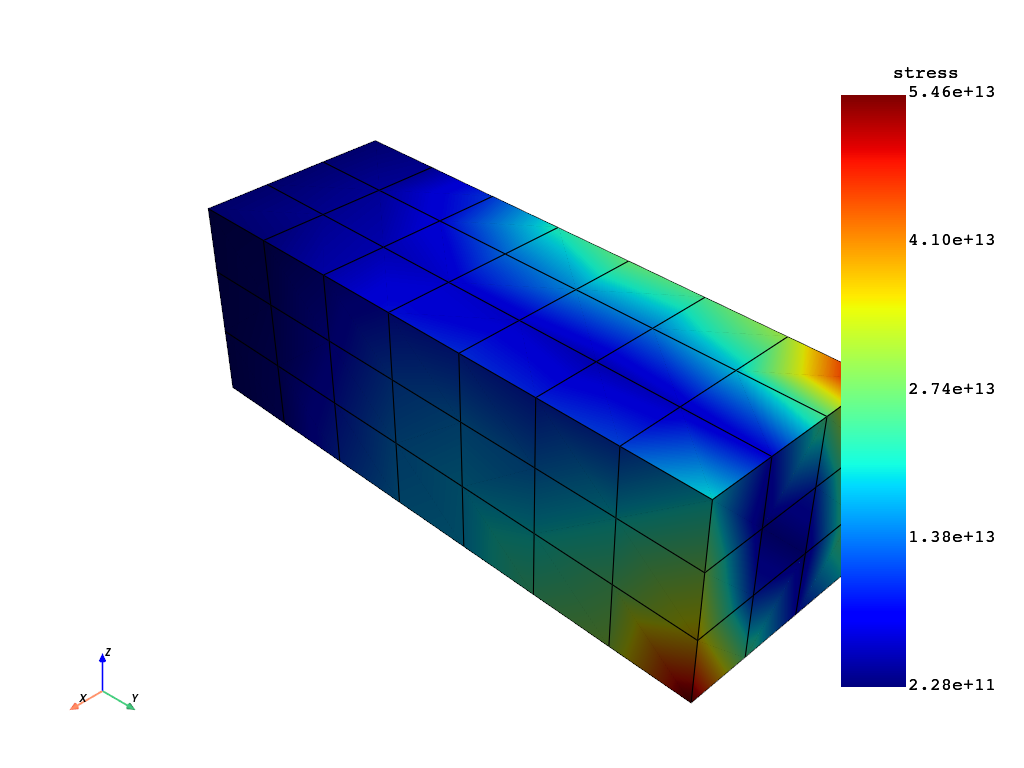

In [7]:
nodal = ops.averaging.to_nodal_fc(merge)

merge.connect(0, remote_operators[0], 0)
merge.connect(1, remote_operators[1], 0)

fc = nodal.get_output(0, dpf.types.fields_container)
print(fc[0])
fc[0].meshed_region.plot(fc[0])